In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers

train_dataset = image_dataset_from_directory(
    "cats_vs_dogs_small\\train",
    image_size=(180,180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    "cats_vs_dogs_small\\validation",
    image_size=(180,180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    "cats_vs_dogs_small\\test",
    image_size=(180,180),
    batch_size=32)

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180,180,3)
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
58889256/58889256 [==============================] - 27s 0us/step


In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

## extracting the VGG16 features and corresponding labels

In [3]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)


1/1 [==============================] - 0s 21ms/step


In [4]:
print(train_features.shape)

(2000, 5, 5, 512)


In [5]:
#Defining ND TRAINING  the densely connected classifier

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
             optimizer="rmsprop",
             metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks
)

Epoch 1/20
63/63 [==============================] - 2s 14ms/step - loss: 16.1639 - accuracy: 0.9245 - val_loss: 3.1079 - val_accuracy: 0.9760
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 4.1479 - accuracy: 0.9750 - val_loss: 4.5391 - val_accuracy: 0.9660
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 2.8147 - accuracy: 0.9815 - val_loss: 6.2968 - val_accuracy: 0.9650
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 2.4557 - accuracy: 0.9860 - val_loss: 5.0065 - val_accuracy: 0.9710
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 0.4753 - accuracy: 0.9945 - val_loss: 4.0290 - val_accuracy: 0.9800
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 1.4901 - accuracy: 0.9865 - val_loss: 3.4774 - val_accuracy: 0.9810
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 0.3731 - accuracy: 0.9980 - val_loss: 4.8621 - val_accuracy: 0.9800
Epoch 8/20
63/63 [

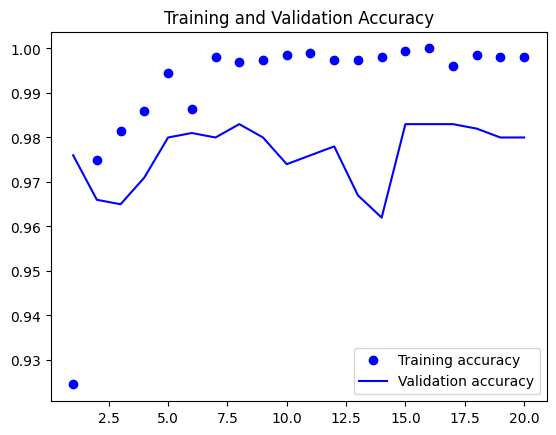

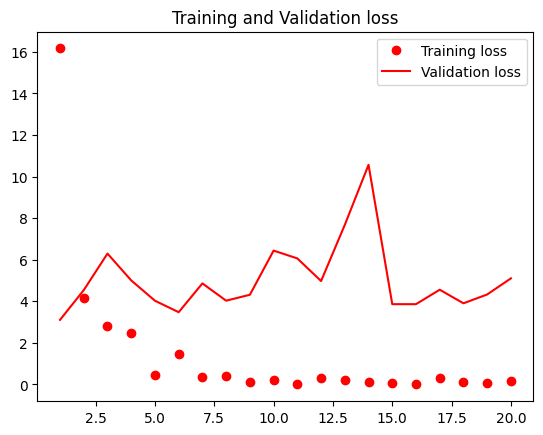

In [6]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()